In [3]:
from random import randint, sample
from hypergraphs import *
from qf import graphs
import networkx as nx
import math


n = 7            # Number of nodes of BH
m = 12            # Number of hyperarcs of BH
multiplicity = 6 # Maximum size of a fibre over BH

In [5]:
def gen_hyper(n, m, max_source=-1):
    """
        Returns a directed hypergraph with n nodes and m hyperarcs. Each hyperarc can have up to max_source sources (if unspecified, n).
        All hyperarcs are named "h_{i}" where i is a consecutive value.
    """
    if max_source < 0:
        max_source = n
    BH = hnx.Hypergraph()
    for i in range(m):
        k = randint(1, min(max_source, n))  # Number of sources
        sources = sample(range(0, n), k)
        target = randint(0, n)
        add_directed_hyperedge(BH, sources, target, f"h_{i}")    
    return BH

In [6]:
def left_hyper(BH, multiplicity):
    """
        Lifts the hypergraph BH, with fibers of cardinality up to multiplicity.
        The resulting graph has:
        - nodes are named (x,i) where x is a node of BH and i is in range(k), k being the size of the fiber over k
        - hyperarcs are named h_{i} where h is a hyperarc of BH and i is in range(k), k being the size of the fiber over the target of h.
        The function returns the lifted hypergraph, and a dictionary mapping the nodes (as strings) of the 
        result to the nodes of the original graph.
    """
    map = {}
    B, dd = hg2g(BH) # Lift every node
    resdd = {}
    lifting = {}
    for x in B.nodes():
        if dd[x] == 0: # Node, liftable
            lifting[x]=list(range(randint(1, multiplicity)))   # Multiplicity of nodes
            for i in lifting[x]:
                    resdd[str((x, i))] = x
    H = hnx.Hypergraph() # Generate H appropriately
    for h in BH.edges():
        name = str(h)
        target = h.props['target']
        sources = set([x for x in h.elements])-set([target])
        for t in lifting[target]:
            ss = []
            for s in sources:
                s_lift = sample(lifting[s], 1)[0]
                ss += [(s, s_lift)]
            add_directed_hyperedge(H, ss, (target, t), "{}_{}".format(name, t))
    return H, resdd


In [7]:
def nodes2id(H):
    """
        Returns a dictionary with one entry for every node of H, which is a monotone minimal perfect hashing. 
        The entry related to node x has key str(x).
    """
    s = enumerate(sorted([str(x) for x in H.nodes()]))
    return {t[1]: t[0] for t in s}

In [8]:
BH = gen_hyper(3,7)
H, dd = left_hyper(BH,3)

idBH = nodes2id(BH)       # Nodes of BH are mapped to numbers (ids)   
idH = nodes2id(H)        # Nodes of H are mapped to numbers (ids)
idH2B = [idBH[str(dd[x])] for x in [{v: k for k,v in idH.items()}[i] for i in range(len(idH))]]
                         # Maps each id of H to the corresponding id of BH

In [9]:
def model_for(H, idH):
    """
        Returns the model for the hypergraph H, using idH for ids (see nodes2id).
        This model contains len(idH) variables and equations.
        Let y[i] denote the i-th variable. 
        Let x be a node of H. Then y'[idH[x]] is obtained as follows: for every 
        hyperarc h with target x, you take the product of y[s] for all sources s of x.
        You sum these products
    """
    def model(y, t):
        res = [0 for x in range(len(idH))]
        for h in H.edges():
            target = idH[str(h.props['target'])]
            sources = set([idH[str(x)] for x in h.elements])
            p = 1
            for s in sources:
                p *= math.cos(y[s])
            res[target] += p
        return res
    return model

In [10]:
mmH = model_for(H, idH)
mmB = model_for(BH, idBH)

In [11]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


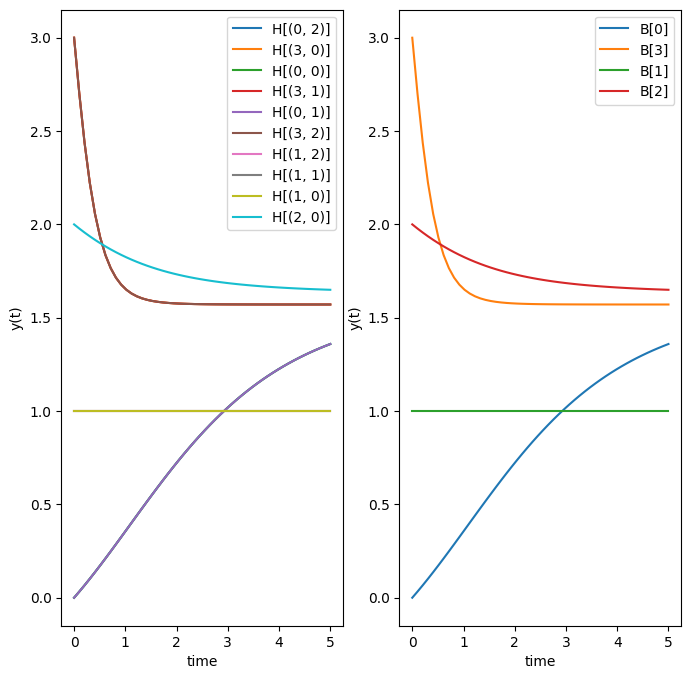

In [12]:
# initial condition
y0B = range(BH.number_of_nodes())
y0H = [y0B[idH2B[x]] for x in range(H.number_of_nodes())]

# time points
t = np.linspace(0,5)

# solve ODE
yB = odeint(mmB, y0B, t)
yH = odeint(mmH, y0H, t)

# node of H to look at
node = 3

# plot results
f, (ax1, ax2) = plt.subplots(1, 2)

for n in H.nodes():
    node = str(n)
    nodeid = idH[node]
    ax1.plot(t,[yH[i][nodeid] for i in range(len(t))], label=f"H[{node}]")
    
for n in BH.nodes():
    node = str(n)
    nodeid = idBH[node]
    ax2.plot(t,[yB[i][nodeid] for i in range(len(t))], label=f"B[{node}]")

ax1.set_xlabel('time')
ax1.set_ylabel('y(t)')
ax1.legend()
ax2.set_xlabel('time')
ax2.set_ylabel('y(t)')
ax2.legend()

plt.show()

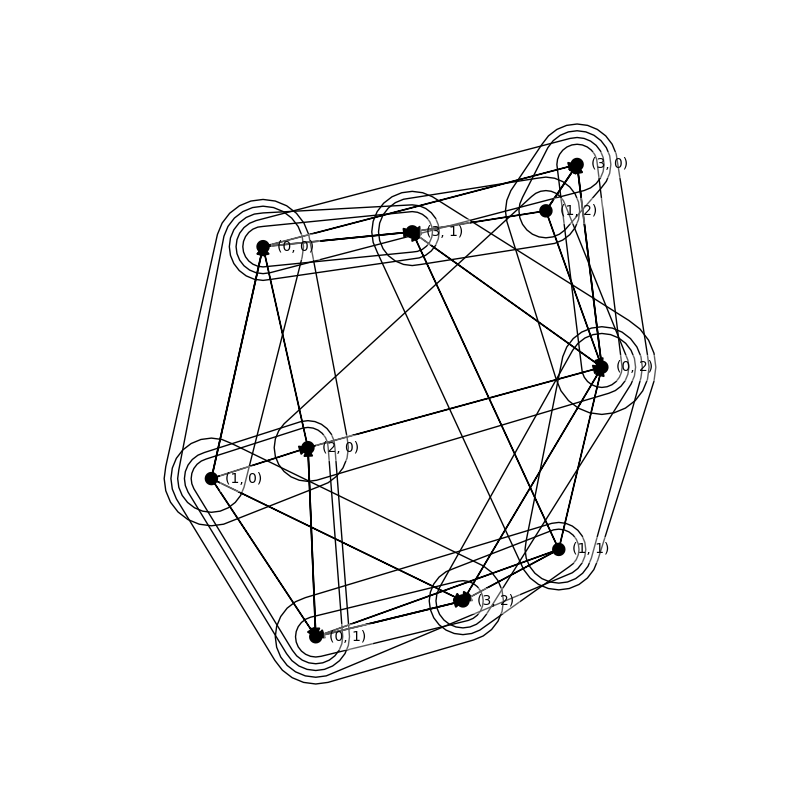

In [15]:
visualize_hg(H)

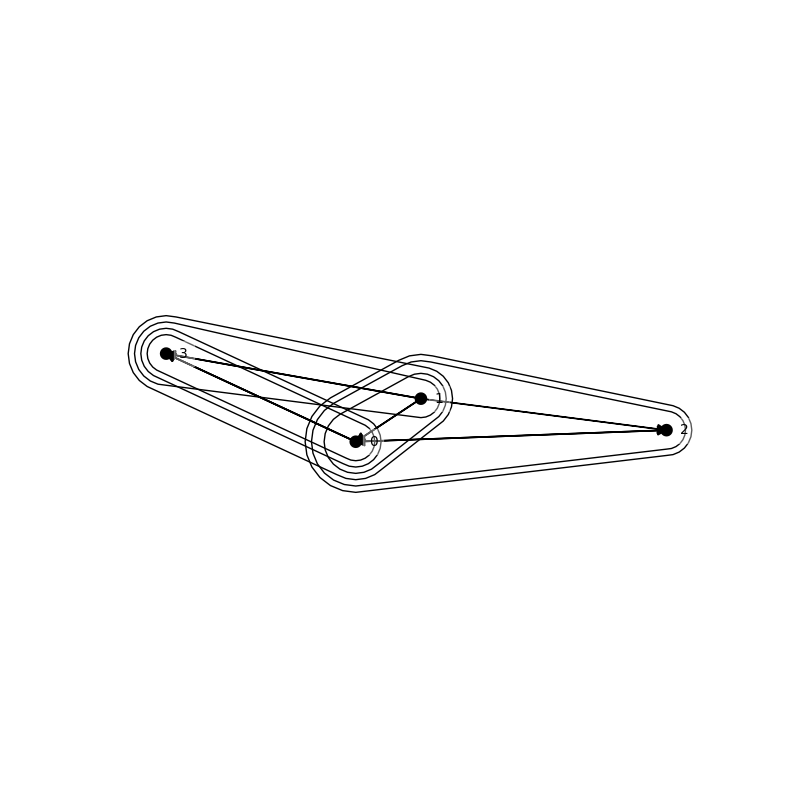

In [16]:
visualize_hg(BH)